# Solving Iris classification with Neural Networks

In this practice you will apply different Neural Networks models to solve classification problem based on IRIS dataset.

<div>
    <img src="images/svm_irises.png" width="800"/>
</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
%matplotlib inline

To load Iris dataset there is no need to go directly to kaggle, etc. Now, almost every well-known dataset is presented in the frameworks out of the box. The same SKLearn does.

To get dataset simply use ```dataset``` package & do ```.load_``` of corresponding data.

In [2]:
iris = datasets.load_iris()

Lets investigate the given data

In [3]:
# first understand the type of the object:
print(type(iris))

# searching for "sklearn.utils.Bunch" navgates to https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html object description => hence this is just a key-value object
print(iris.keys())

# > dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In Python accessing values could be done in different way, e.g.:
```
> print(iris.data)
```
or by addressing property by name:
```
> print(iris["data"])
```

Note! property names are case-sensitive

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
# create a pandas dataframe based on the iris' data,
# note: we're adding target column separately, cause it is not in the data object

df = pd.DataFrame(iris.data, columns = iris.feature_names)
#df['target'] = iris.target
df['target'] = iris.target_names[iris.target]

In [6]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import pickle

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Select a fixed random seed for reproducibility
mx.random.seed(42)

In [8]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

### Load data

In [9]:
X = iris.data
y = iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.25)

In [10]:
train_data = mx.gluon.data.dataset.ArrayDataset(mx.nd.array(X_train), mx.nd.array(y_train))
test_data = mx.gluon.data.dataset.ArrayDataset(mx.nd.array(X_test), mx.nd.array(y_test))

In [11]:
sample_no = 23
inputs, label = train_data[sample_no]
print(inputs)
print(label)



[6.4 2.7 5.3 1.9]
<NDArray 4 @cpu(0)>
2.0


### Train

In [12]:
net = nn.Sequential(prefix='MLP_')
with net.name_scope():
    net.add(
        nn.Dense(128, activation='relu'),
        nn.Dense(64, activation='relu'),
        nn.Dense(3, activation=None)
    )

In [13]:
batch_size = 32
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [14]:
net.initialize(mx.init.Xavier(), ctx=ctx)

In [15]:
trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.01},
)

In [16]:
metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

In [17]:
num_epochs = 10
history = []

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        # Forward pass
        with autograd.record():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)

        # Backpropagation
        loss.backward()
        metric.update(labels, outputs)

        # Update
        trainer.step(batch_size=inputs.shape[0])

    # Print the evaluation metric and reset it for the next epoch
    name, acc = metric.get()
    history.insert(epoch,acc)
    print('.', end='')
    metric.reset()

print('[Done]')

..........[Done]


Text(0.5, 0, 'Epoch')

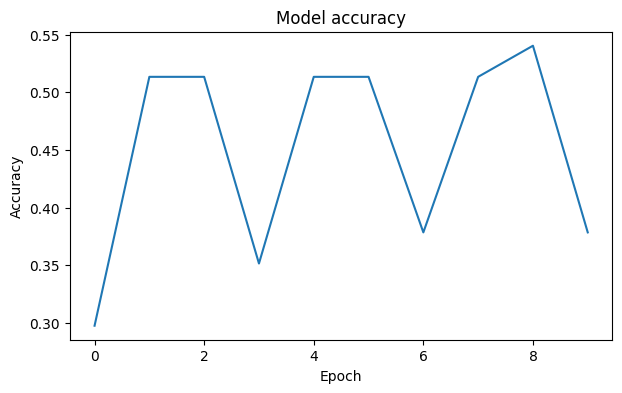

In [18]:
plt.figure(figsize=(7, 4))
plt.plot(history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

### Evaluate

In [19]:
test_loader = mx.gluon.data.DataLoader(test_data, shuffle=False, batch_size=batch_size)
#train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [20]:
metric = mx.metric.Accuracy()
for inputs, labels in test_loader:
    # Possibly copy inputs and labels to the GPU
    inputs = inputs.as_in_context(ctx)
    #print(inputs)
    labels = labels.as_in_context(ctx)
    metric.update(labels, net(inputs))
    
print('Validaton: {} = {}'.format(*metric.get()))

Validaton: accuracy = 0.5752212389380531


### Task: create confusion matrix

### Sample prediction

In [21]:
'''
sample_no = 1

sample, label = test_data[sample_no]
p = net(test_data)
#p = net(sample)
'''

ValueError: In HybridBlock, there must be one NDArray or one Symbol in the input. Please check the type of the args.


In [ ]:
'''
predictions = []
test_labels = []

for i in test_data:
    pred_sample, pred_label = i
    p = net(pred_sample)
    predictions.append(p)
    test_labels.append(pred_label)
'''

MXNetError: Shape inconsistent, Provided = [128,4], inferred shape=(128,1)